In [51]:
import math
import numpy as np
import matplotlib.pylab as plt
# from bokeh.plotting import figure, output_file, show
# from bokeh.io import output_notebook
import palettable

import pic_information
from cori_3d import div0, find_nearest
from json_functions import read_data_from_json

COLORS = palettable.colorbrewer.qualitative.Set1_9.mpl_colors

In [52]:
species = 'e'
tframe = 7
mime = 25
bg = 0.0

In [53]:
bg_str = str(int(bg * 10)).zfill(2)
pic_run = "mime" + str(mime) + "_beta002_bg" + bg_str
pic_run_dir = '/net/scratch3/xiaocanli/reconnection/mime' + str(mime) + '/' + pic_run + '/'
picinfo_fname = '../data/pic_info/pic_info_' + pic_run + '.json'
pic_info = read_data_from_json(picinfo_fname)
nx, ny, nz = pic_info.nx, pic_info.ny, pic_info.nz
pmass = 1 if species == 'e' else pic_info.mime
vth = pic_info.vthe if species == 'e' else pic_info.vthi
gama = 1.0 / math.sqrt(1.0 - 3 * vth**2)
eth = (gama - 1) * pmass

Reading ../data/pic_info/pic_info_mime25_beta002_bg00.json


In [69]:
# particle acceleration rate
fpath = '../data/particle_interp/' + pic_run + '/'
tindex = pic_info.particle_interval * tframe
fname = fpath + "particle_energization_" + species + "_" + str(tindex) + ".gda"
fdata = np.fromfile(fname, dtype=np.float32)
nbins = int(fdata[0])
nbinx = int(fdata[1])
nvar = int(fdata[2])
ebins = fdata[3:nbins+3]
fbins = fdata[nbins+3:].reshape((nvar, nbinx, nbins))
ebins *= pmass / eth
eindex1, e1 = find_nearest(ebins, 1)
eindex2, e2 = find_nearest(ebins, 1000)

# The standard deviation of $\alpha$

/usr/projects/particle/xiaocanli/xlipy/xlipy3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


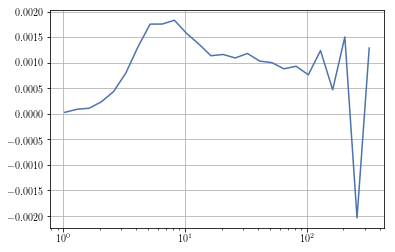

In [73]:
alpha = np.sum(fbins, axis=1)
alpha_sq = div0(alpha[1:(nvar+1)//2], alpha[0])**2
alpha2 = div0(alpha[(nvar+1)//2:], alpha[0])
alpha_std = alpha2 - alpha_sq
# alpha_std[alpha_std<0] = 0
alpha_std = np.sqrt(alpha_std)
# p1 = plt.semilogx(ebins[eindex1:eindex2],
#                   alpha_std[1, eindex1:eindex2])
p1 = plt.semilogx(ebins[eindex1:eindex2],
                  alpha[2, eindex1:eindex2] / alpha[0, eindex1:eindex2])
# p1 = plt.semilogx(ebins[eindex1:eindex2],
#                   alpha2[1, eindex1:eindex2])
# p2 = plt.semilogx(ebins[eindex1:eindex2],
#                   alpha_sq[1, eindex1:eindex2])
plt.grid(True)
# print(alpha[2, eindex1:eindex2]/alpha[0, eindex1:eindex2])
# print(alpha[2, eindex1:eindex2])
# print(alpha[0, eindex1:eindex2])

In [56]:
# the distributions of particle acceleration rates
fname = fpath + "acc_rate_dist_" + species + "_" + str(tindex) + ".gda"
fdata = np.fromfile(fname, dtype=np.float32)
nalpha = int(fdata[0]) # number of bins of the rates
nbins = int(fdata[1])  # number of bins along x
nbinx = int(fdata[2])  # number of energy bins
nvar = int(fdata[3])   # number of variables
ebins = fdata[4:nbins+4]  # energy bins
alpha_bins = fdata[nbins+4:nbins+nalpha+4]  # acceleration rates bins
fdist = fdata[nbins+nalpha+4:].reshape((nvar, nbinx, nbins, (nalpha + 1)*4))
ebins *= pmass / eth

In [57]:
fbins1 = np.zeros([nvar+1, nbinx, nbins])
ntot = np.sum(fdist[:, :, :, :(nalpha + 1) * 2], axis=-1)
fbins1[0] = ntot[0, :]
fbins1[1:] = np.sum(fdist[:, :, :, (nalpha + 1) * 2:], axis=-1)

In [58]:
# sum over the x-direction
nbins_dist = np.sum(fdist[:, :, :, :(nalpha + 1) * 2], axis=1)
fbins_dist = np.sum(fdist[:, :, :, (nalpha + 1) * 2:], axis=1)

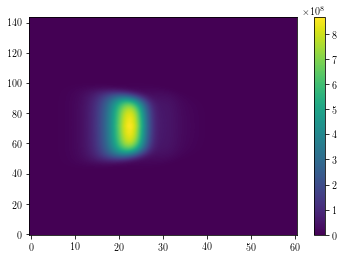

In [59]:
# reorganize the negative and positive alpha distribution
alpha_dist = np.copy(nbins_dist[1, :, :].T)
alpha_bins_sym = np.zeros((nalpha + 2) * 2 - 1)
dalpha_log = math.log10(alpha_bins[1]) - math.log10(alpha_bins[0])
alpha_min = 10**(math.log10(alpha_bins[0]) - dalpha_log)
alpha_max = 10**(math.log10(alpha_bins[-1]) + dalpha_log)
alpha_bins_sym[0] = -alpha_max
alpha_bins_sym[1:nalpha+1] = -alpha_bins[::-1]
alpha_bins_sym[nalpha+1] = 0
alpha_bins_sym[nalpha+2:2*nalpha+2] = alpha_bins
alpha_bins_sym[2*nalpha+2] = alpha_max
alpha_bins_mid = 0.5 * (alpha_bins_sym[:-1] + alpha_bins_sym[1:])
ebins_g, alpha_bins_g = np.meshgrid(ebins, alpha_bins_sym)
dalpha_bins_g = np.diff(alpha_bins_g, axis=0)
alpha_dist /= dalpha_bins_g
ebins_g, alpha_bins_g = np.meshgrid(ebins, alpha_bins_mid)
# plt.pcolormesh(ebins, alpha_bins_mid, alpha_dist,
#                cmap=plt.cm.viridis)
# plt.xscale('log')
# plt.yscale('symlog')
im = plt.imshow(alpha_dist, cmap=plt.cm.viridis,
                aspect='auto', origin='lower', interpolation='bicubic')
cbar = plt.colorbar(im)

# The distributions of $\alpha$ for different $x$

In [60]:
nbins_dist_x = np.sum(fdist[:, :, :, :(nalpha + 1) * 2], axis=3)
fbins_dist_x = np.sum(fdist[:, :, :, (nalpha + 1) * 2:], axis=3)
arate_dist_x = div0(fbins_dist_x, nbins_dist_x)
arate_dist_x /= pmass
sz = arate_dist_x.shape
arate_dist_xr = np.mean(arate_dist_x.reshape(sz[0], -1, 16, sz[2]), axis=2)
sz = arate_dist_xr.shape

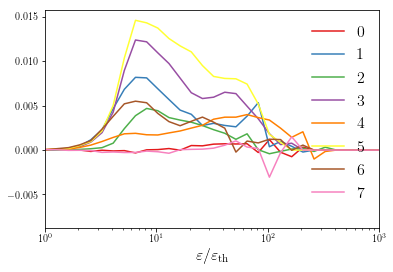

In [61]:
plt.gca().axes.set_prop_cycle('color', COLORS)
for ix in range(sz[1]):
    plt.semilogx(ebins, arate_dist_xr[1, ix, :], label=str(ix))
plt.xlim([1, 1E3])
plt.xlabel(r'$\varepsilon/\varepsilon_\text{th}$', fontsize=16)
p1 = plt.legend(loc=1, prop={'size': 16}, ncol=1,
                shadow=False, fancybox=False, frameon=False)

## Compare two methods to calculate the acceleration rates

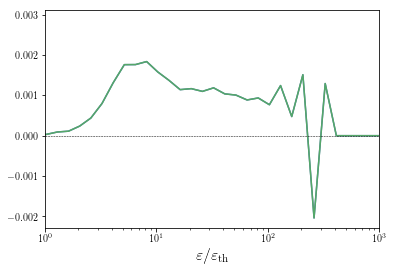

In [62]:
rate = np.sum(fbins_dist[1, :, :], axis=1)
nacc = np.sum(nbins_dist[1, :, :], axis=1)
rate = div0(rate, nacc * pmass)
p1, = plt.semilogx(ebins, rate)
p2, = plt.semilogx(ebins, div0(np.sum(fbins[2], axis=0),
                               np.sum(fbins[0], axis=0) * pmass))
p3 = plt.xlim([1, 1E3])
p4, = plt.plot([1, 1E3], [0, 0], color='k',
               linewidth=0.5, linestyle='--')
l1 = plt.xlabel(r'$\varepsilon/\varepsilon_\text{th}$', fontsize=16)

# Pressure Anisotropy

In [63]:
def read_pressure_anisotropy(pic_run, tframe):
    """read pressure anisotropy data
    """
    fpath = '../data/particle_interp/' + pic_run + '/'
    tindex = pic_info.particle_interval * tframe
    fname = fpath + "anisotropy_" + species + "_" + str(tindex) + ".gda"
    fdata = np.fromfile(fname, dtype=np.float32)
    nvar = int(fdata[0])
    nbins = int(fdata[1])
    nbinx = int(fdata[2])
    ebins = fdata[3:nbins+3]
    faniso = fdata[nbins+3:].reshape((nbinx, nbins, nvar))
    ebins *= pmass
    return (ebins, faniso)

In [64]:
ebins, fdata = read_pressure_anisotropy(pic_run, tframe)
ebins /= eth

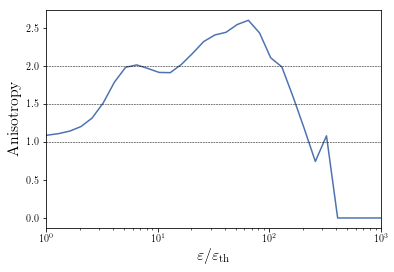

In [65]:
fdata_ene = np.sum(fdata, axis=0)
faniso_ene = div0(fdata_ene[:, 1], fdata_ene[:, 2])
p1, = plt.semilogx(ebins, faniso_ene)
plt.xlim([1, 1E3])
p2, = plt.plot([1, 1E3], [1, 1], color='k',
               linestyle='--', linewidth=0.5)
p3, = plt.plot([1, 1E3], [1.5, 1.5], color='k',
               linestyle='--', linewidth=0.5)
p4, = plt.plot([1, 1E3], [2.0, 2.0], color='k',
               linestyle='--', linewidth=0.5)
t1 = plt.xlabel(r'$\varepsilon/\varepsilon_\text{th}$', fontsize=16)
t2 = plt.ylabel('Anisotropy', fontsize=16)

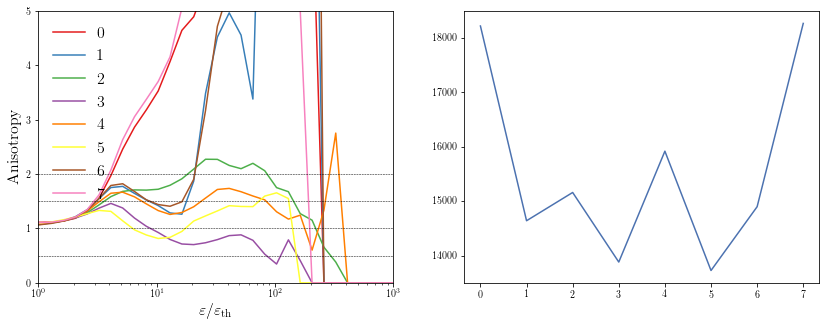

In [66]:
nbinx, nbins, nvar = fdata.shape
fdata_x = np.sum(fdata.reshape([8, -1, nbins, nvar]), axis=1)
faniso_x_ene = div0(fdata_x[:, :, 1], fdata_x[:, :, 2])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_prop_cycle('color', COLORS)
for ix in range(8):
    p1, = ax1.semilogx(ebins, faniso_x_ene[ix, :], label=str(ix))
ax1.plot([1, 1E3], [0.5, 0.5], color='k', linewidth=0.5, linestyle='--')
ax1.plot([1, 1E3], [1, 1], color='k', linewidth=0.5, linestyle='--')
ax1.plot([1, 1E3], [2, 2], color='k', linewidth=0.5, linestyle='--')
ax1.plot([1, 1E3], [1.5, 1.5], color='k', linewidth=0.5, linestyle='--')
ax1.set_xlim([1, 1E3])
ax1.set_ylim([0, 5])
p2 = ax1.legend(loc=2, prop={'size': 16}, ncol=1,
                shadow=False, fancybox=False, frameon=False)
ax1.set_xlabel(r'$\varepsilon/\varepsilon_\text{th}$', fontsize=16)
ax1.set_ylabel('Anisotropy', fontsize=16)
p3, = ax2.plot(np.sum(fdata_x[:, :, 0], axis=-1))

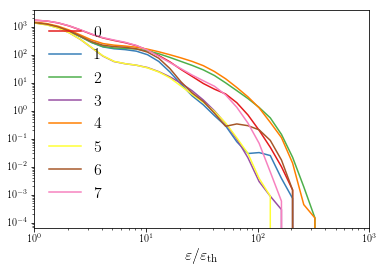

In [67]:
plt.gca().axes.set_prop_cycle('color', COLORS)
for ix in range(8):
    plt.loglog(ebins, fdata_x[ix, :, 0], label=str(ix))
plt.xlim([1, 1E3])
p2 = plt.legend(loc=2, prop={'size': 16}, ncol=1,
                shadow=False, fancybox=False, frameon=False)
t1 = plt.xlabel(r'$\varepsilon/\varepsilon_\text{th}$', fontsize=16)